In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
import cv2

# Define dataset paths
dataset_dir = 'model_pics'  # Update this to your dataset path
violence_dir = os.path.join(dataset_dir, 'quarrel')
toilet_dir = os.path.join(dataset_dir, 'washrooms')
coach_dir = os.path.join(dataset_dir, 'coaches')


In [2]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split data into training and validation sets
)

# Load training and validation data
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 511 images belonging to 3 classes.
Found 127 images belonging to 3 classes.


In [7]:
# Transfer learning with VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

# Building the Sequential Model
model = Sequential([
    base_model,
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Use padding='same'
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),  # This will reduce the spatial dimensions by half
    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Use padding='same'
    BatchNormalization(),
    GlobalAveragePooling2D(),  # Apply GlobalAveragePooling2D here to prevent further shrinking
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# Callbacks for learning rate reduction and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [14]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[lr_reduction, early_stopping]
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9904 - loss: 0.0288 - val_accuracy: 0.8898 - val_loss: 0.3041 - learning_rate: 5.0000e-04
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.9869 - loss: 0.0646 - val_accuracy: 0.7874 - val_loss: 0.6520 - learning_rate: 5.0000e-04
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 104s 7s/step - accuracy: 0.9675 - loss: 0.0967 - val_accuracy: 0.8740 - val_loss: 0.4426 - learning_rate: 5.0000e-04
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9821 - loss: 0.0336
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 0.9818 - loss: 0.0346 - val_accuracy: 0.8819 - val_loss: 0.4323 - learning_rate: 5.0000e-04
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9859 - loss: 0.0512 - val_accuracy: 0.8425 - val_loss: 0.4990 - learning_rate: 2.5000e-04


In [15]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9018 - loss: 0.2762
Validation Accuracy: 89.76%


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Classification Report:
              precision    recall  f1-score   support

     coaches       0.22      0.27      0.24        30
     quarrel       0.43      0.39      0.41        51
   washrooms       0.41      0.39      0.40        46

    accuracy                           0.36       127
   macro avg       0.35      0.35      0.35       127
weighted avg       0.37      0.36      0.37       127



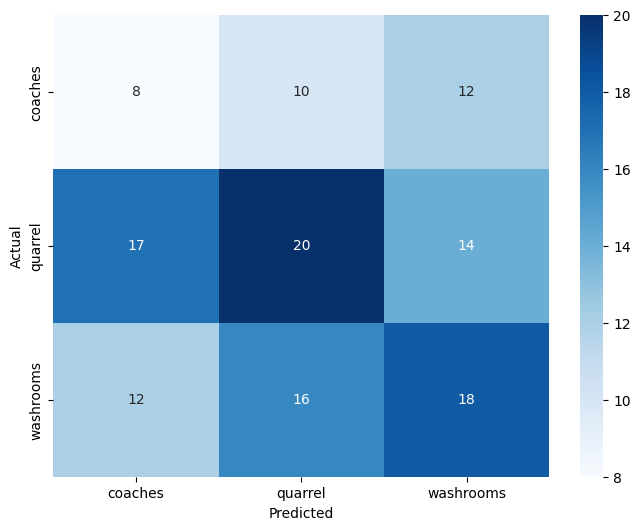

In [16]:
# Predict on validation data
validation_generator.reset()
preds = model.predict(validation_generator)
y_pred = np.argmax(preds, axis=1)
y_true = validation_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [17]:
# Save the model
model.save('image_classification_model.h5')
